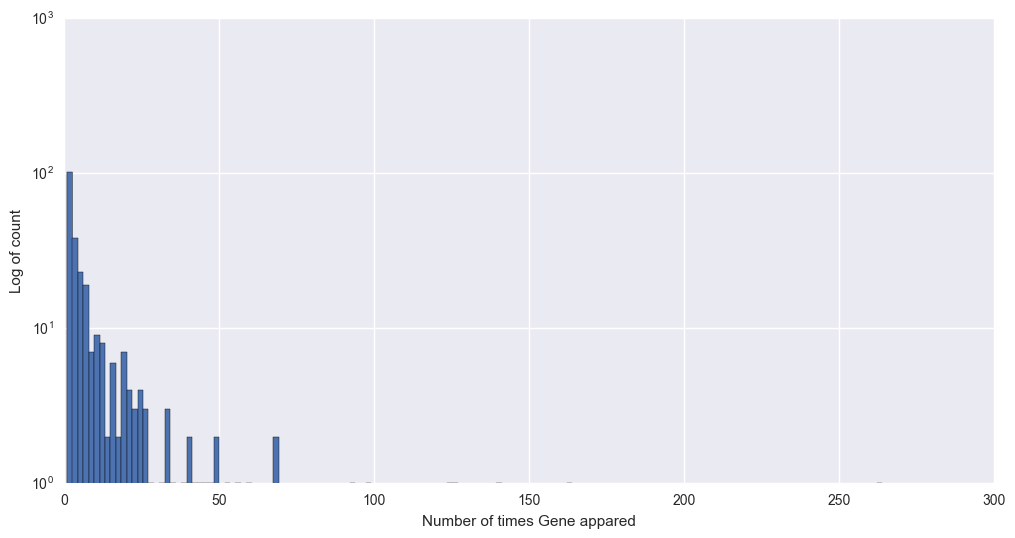

Counter({'BRCA1': 264, 'TP53': 163, 'EGFR': 141, 'PTEN': 126, 'BRCA2': 125, 'KIT': 99, 'BRAF': 93, 'ALK': 69, 'ERBB2': 69, 'PDGFRA': 60, 'PIK3CA': 56, 'CDKN2A': 52, 'FGFR2': 50, 'FLT3': 49, 'TSC2': 47, 'MTOR': 45, 'KRAS': 44, 'MAP2K1': 43, 'VHL': 41, 'RET': 40, 'FGFR3': 39, 'MLH1': 35, 'JAK2': 33, 'MET': 33, 'SMAD4': 33, 'NOTCH1': 31, 'AKT1': 28, 'ROS1': 26, 'ABL1': 26, 'PTPN11': 26, 'CBL': 25, 'CTNNB1': 25, 'PIK3R1': 24, 'RUNX1': 24, 'SMAD3': 23, 'PTPRT': 23, 'PDGFRB': 23, 'HRAS': 22, 'NFE2L2': 22, 'MSH2': 21, 'SMO': 21, 'TSC1': 20, 'AR': 20, 'SPOP': 20, 'ERBB4': 20, 'FBXW7': 19, 'SMAD2': 19, 'ERCC2': 19, 'JAK1': 18, 'RHOA': 17, 'NTRK1': 16, 'NF1': 16, 'IDH1': 16, 'SF3B1': 16, 'ESR1': 16, 'PMS2': 16, 'KEAP1': 14, 'TET2': 14, 'FGFR1': 13, 'MSH6': 13, 'STK11': 13, 'CCND1': 13, 'RAF1': 12, 'CARD11': 12, 'PPP2R1A': 12, 'NRAS': 12, 'EWSR1': 11, 'MAP2K2': 11, 'NF2': 11, 'AKT2': 11, 'ERBB3': 11, 'PIK3CB': 10, 'RB1': 10, 'CDK12': 10, 'POLE': 10, 'EP300': 9, 'CDH1': 9, 'BAP1': 9, 'MAP2K4': 9, 

In [1]:

from gensim.summarization import summarize
from gensim.summarization import keywords

# Text analysis helper libraries for word frequency etc..
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation


from scipy.misc import imresize
from PIL import Image

from collections import Counter

# Word2Vec related libraries
from gensim.models import KeyedVectors

#NLP

#Importing dataset
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#Importing Dataset
#import os
#os.chdir('D:\Py-R\cancer')
import os
os.chdir('/home/shraddha/cancer')
source= '/home/shraddha/cancer'

train_variant = pd.read_csv(source+'/training_variants')
test_variant = pd.read_csv(source+'/test_variants')

train_text = pd.read_csv(source+'/training_text',sep = '\|\|', engine= 'python', header=None, 
                     skiprows=1, names=["ID","Text"])
test_text = pd.read_csv(source+'/test_text',sep = '\|\|', engine= 'python', header=None, 
                     skiprows=1, names=["ID","Text"])

train = pd.merge(train_variant, train_text, how = 'left', on = 'ID').fillna('')
test = pd.merge(test_variant, test_text, how = 'left', on = 'ID').fillna('')


#Data Exploration
train.Gene.nunique()
train['Gene'].unique()

k = train.groupby('Gene')['Gene'].count()

plt.figure(figsize=(12,6))
plt.hist(k, bins=150,log=True)
plt.xlabel('Number of times Gene appared')
plt.ylabel('Log of count')
plt.show()

#count Gene
from collections import Counter
plt.figure(figsize=(12,10))
sns.countplot((train['Gene']))
plt.xticks()
genecount = Counter(train['Gene'])
print(genecount,'\n',len(genecount))



plt.figure(figsize=(12,6))

In [2]:
#cleaning of data
def cleantext(train):
    corpus = []
    for i in range(0,train.shape[0]):
        review = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]"," ",train['Text'][i])
        review = review.lower().split()
        ps = PorterStemmer()
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    
    return corpus

corp_train = cleantext(train)
corp_test = cleantext(test)

# Determine lenght of text
def textlen(train):
    k = train['Text'].apply(lambda x: len(str(x).split()))
    l = train['Text'].apply(lambda x: len(str(x)))
    return k, l

train['Text_no_word'], train['Text_no_char'] = textlen(train)
test['Text_no_word'], test['Text_no_char'] = textlen(test)

#
for i in range(10):
    print('\n Doc', str(i))
    stopcheck = Counter(corp_train[i].split())
    print(stopcheck.most_common()[:10])

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
	min_df=1, max_features=1600, strip_accents='unicode',lowercase =True,
	analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
	smooth_idf=True, sublinear_tf=True, stop_words = 'english'
).fit(train)

X_train = tfidf.transform(corp_train).toarray()
print(X_train)

X_test = tfidf.transform(corp_test).toarray()

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
y_train = train['Class']

#Converting to categorical variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
y_train=le.fit_transform(y_train)
#onh = OneHotEncoder(categorical_features = [0])
#y_train =onh.fit_transform(y_train).toarray()

# Preparing model
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=5000,max_depth=8,min_samples_split=2)
classifier.fit(X_train,y_train)

#Predict
y_pred=classifier.predict_proba(X_test)
y=pd.DataFrame(y_pred)
#np.mean(y_pred==y_train)

submit = pd.DataFrame(test.ID)
submit = submit.join(pd.DataFrame(y_pred))
submit.columns = ['ID', 'class1','class2','class3','class4','class5','class6','class7','class8','class9']

submit.to_csv('submission.csv', index=False)


 Doc 0
[('cyclin', 91), ('.', 81), ('cdk10', 65), ('fig.', 63), ('express', 59), ('cell', 58), ('protein', 50), ('ets2', 46), ('level', 41), (',', 39)]

 Doc 1
[('c-cbl', 139), ('mutat', 103), ('.', 82), ('cell', 78), ('lung', 56), (',', 48), ('egfr', 38), ('1', 33), ('sampl', 33), ('met', 32)]

 Doc 2
[('c-cbl', 139), ('mutat', 103), ('.', 82), ('cell', 78), ('lung', 56), (',', 48), ('egfr', 38), ('1', 33), ('sampl', 33), ('met', 32)]

 Doc 3
[('cbl', 101), ('mutat', 94), ('case', 65), ('.', 41), ('upn', 38), ('cell', 37), ('aupd', 37), ('figur', 35), ('2', 30), ('analysi', 25)]

 Doc 4
[('mutat', 150), ('cbl', 113), ('.', 95), ('cancer', 63), ('bind', 62), ('activ', 58), ('protein', 45), ('effect', 40), ('cell', 38), ('stabil', 35)]

 Doc 5
[('mutat', 150), ('cbl', 113), ('.', 95), ('cancer', 63), ('bind', 62), ('activ', 58), ('protein', 45), ('effect', 40), ('cell', 38), ('stabil', 35)]

 Doc 6
[('mutat', 150), ('cbl', 113), ('.', 95), ('cancer', 63), ('bind', 62), ('activ', 58), (